# Задача проекта

- Заказчик: Благотворительный фонд “Бюро добрых дел”
- Основная цель заказчика заключается в том, чтобы из пула тех клиентов, которые жертвовали за последний год, выявить клиентов, которые могут увеличить частоту или размер пожертвований.
- Данные, которыми располагает заказчик, включают в себя историю платежей жертвователей и какую-то дополнительную информацию за несколько лет по четырём тысячам жертвователей.
- Жизненный цикл жертвователя составляет от полутора до трёх лет, поэтому в истории будут примеры того, как именно меняется характер платежей клиентов.
- Если получится на основе данных сделать дополнительную сегментацию, например выделить характерное поведение пользователей, которые прекращают жертвовать, это также интересует заказчика.
- Данные реальные, задача интересная, успешное её решение приведёт к тому, что больше людей получат ту помощь, в которой нуждаются.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import phik
import lightgbm as lgb
import shap

In [2]:

from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from catboost import cv, Pool
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from phik import resources, report
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:

donors = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')


In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

# Датасет donors

In [5]:
table_info(donors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


None

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT


Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,ID,Пол,Город,Дата последней email активности
count,3683,2431,1015,1835
unique,3683,2,234,653
top,AF575B85-917F-475D-8875-00055586E05B,Женский ...,Москва,2022-07-18 16:29:49
freq,1,1874,458,294
first,NaN,NaN,NaN,2020-01-30 11:41:46
last,NaN,NaN,NaN,2022-07-28 20:34:28


ID                                 0.000000
Пол                                0.339940
Город                              0.724409
Дата последней email активности    0.501765
dtype: float64

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
...,...,...,...,...
3678,C5E55606-9BFC-48C0-BE7F-FFC10A10DF20,Женский ...,NaN,NaT
3679,3CB754A9-7B08-40FB-A350-FFDB291DA9E1,NaN,NaN,NaT
3680,3F073C3B-E567-428E-B16F-FFE09A8D2CE0,Женский ...,NaN,2022-07-18 16:29:34
3681,029C3CEE-2381-4050-8E91-FFE3030218D4,Женский ...,КУШВА,NaT


In [6]:
donors['Пол'].value_counts(dropna=False).to_frame()

,Пол
Женский,1874
NaN,1252
Мужской,557


In [7]:
#топ 10 городов
donors['Город'].value_counts(dropna=False).to_frame().head(10)

,Город
NaN,2668
Москва,458
Санкт-Петербург,78
Краснодар,23
Нижний Новгород,20
Новосибирск,19
Якутск,14
Саратов,13
Ростов-на-Дону,12
Казань,11


In [8]:
donors['Дата последней email активности'].value_counts(dropna=False).to_frame()

,Дата последней email активности
NaT,1848
2022-07-18 16:29:49,294
2022-07-18 16:29:48,229
2022-07-18 16:29:50,163
2022-07-18 16:29:47,114
...,...
2022-06-24 19:09:13,1
2022-07-19 10:00:01,1
2022-07-18 17:22:28,1
2022-07-22 09:42:47,1


In [9]:
donors['Дата последней email активности'].value_counts(dropna=False)

NaT                    1848
2022-07-18 16:29:49     294
2022-07-18 16:29:48     229
2022-07-18 16:29:50     163
2022-07-18 16:29:47     114
                       ... 
2022-06-24 19:09:13       1
2022-07-19 10:00:01       1
2022-07-18 17:22:28       1
2022-07-22 09:42:47       1
2020-10-08 17:42:07       1
Name: Дата последней email активности, Length: 654, dtype: int64

# Датасет donats

In [10]:
table_info(donats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


None

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


,Сумма платежа
count,1.404300e+04
mean,1.720846e+03
std,2.949977e+04
min,1.000000e-02
25%,1.500000e+02
50%,3.500000e+02
75%,7.000000e+02
max,3.000000e+06


Donor ID              0.000000
Дата платежа          0.000000
Сумма платежа         0.000000
Рекуррентный          0.000000
Назначение платежа    0.090365
Канал оплаты          0.000000
dtype: float64

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
...,...,...,...,...,...,...
14038,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
14039,793690C0-6332-4289-96B4-2CF8902ACEF5,2020-12-02 09:59:13,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
14040,69613503-5B71-4690-ACB5-8E783FF915B4,2021-12-26 00:00:00,500.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
14041,144B2E46-2A6A-48DE-92FB-729C3897A2B4,2018-11-27 16:35:01,200.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты


In [11]:
donats['Дата платежа'].min(), donats['Дата платежа'].max()

(Timestamp('2015-07-19 20:10:11'), Timestamp('2022-07-28 19:22:15'))

<AxesSubplot:>

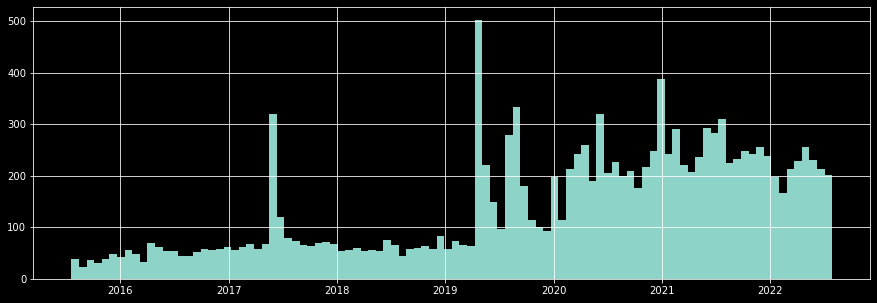

In [12]:
donats['Дата платежа'].hist(figsize = (15, 5), bins=100)

array([[<AxesSubplot:title={'center':'Дата платежа'}>,
        <AxesSubplot:title={'center':'Сумма платежа'}>]], dtype=object)

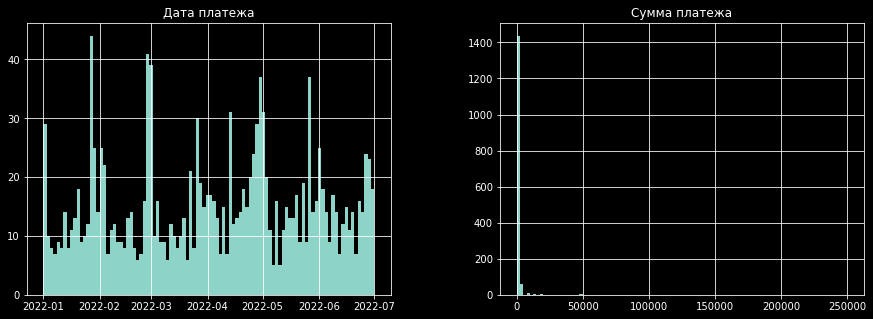

In [13]:
donats[donats['Дата платежа'].between('2022-01-01', '2022-07-01')].hist(figsize = (15, 5), bins=100)

array([[<AxesSubplot:title={'center':'Дата платежа'}>,
        <AxesSubplot:title={'center':'Сумма платежа'}>]], dtype=object)

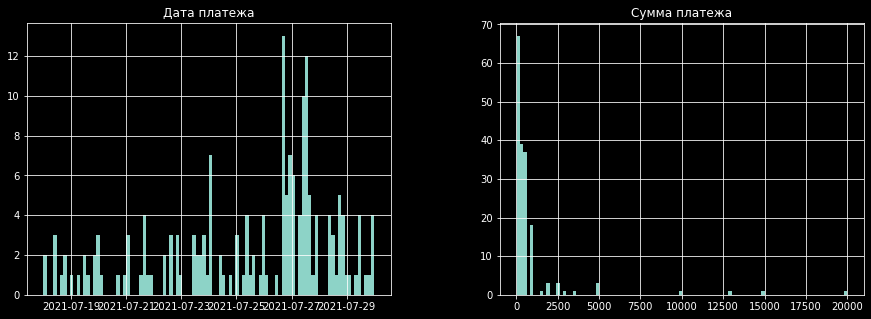

In [14]:
donats[donats['Дата платежа'].between('2021-07-18', '2021-07-30')].hist(figsize = (15, 5), bins=100)

In [15]:
donats['Сумма платежа'].describe().round()

count      14043.0
mean        1721.0
std        29500.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: Сумма платежа, dtype: float64

<AxesSubplot:>

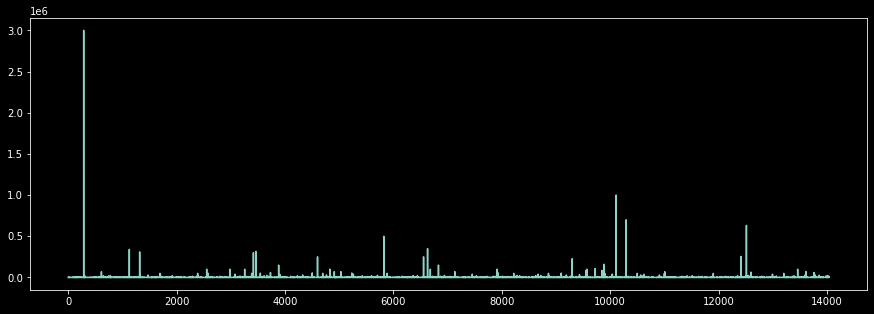

In [16]:
donats['Сумма платежа'].plot(figsize = (15, 5))

<AxesSubplot:>

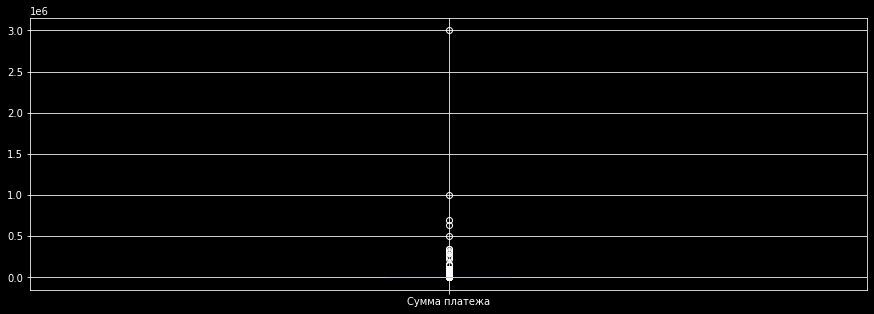

In [17]:
donats.boxplot(column=['Сумма платежа'], figsize = (15, 5))

In [18]:
donats['Рекуррентный'].value_counts(dropna=True).to_frame()

,Рекуррентный
Да,8085
Нет,5958


In [19]:
donats['Назначение платежа'].value_counts(dropna=True).to_frame().head(70)
                                                                    

,Назначение платежа
ПОЖЕРТВОВАНИЕ,3811
"Пожертвование в фонд помощи детям-отказникам и детям-сиротам ""Бюро Добрых Дел""",3335
ПОЖЕРТВОВАНИЕ undefined,2162
Добровольное пожертвование. НДС не облагается,497
SMS bdd,253
...,...
На обучение Дарьи,12
Фотомастерская для Февронии,11
На программу Окно в мир,11
День рождения со смыслом,11


# №2. Предобработка данных

In [20]:
# сравним количество уникальных id в обеих датасетах
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [21]:
#проверим на дубликаты
'Количество дубликатов:', donors.duplicated().sum()


('Количество дубликатов:', 0)

In [22]:
#проверим на дубликаты
'Количество дубликатов:', donats.duplicated().sum()

('Количество дубликатов:', 12)

In [23]:
donats[donats.duplicated() == True]

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
133,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
297,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
1438,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
2837,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
5166,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
7654,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
9594,D38F6A22-9BEF-4484-B377-ED8ED1DB4553,2021-02-11,1.0,Нет ...,ДОБРОВОЛЬНОЕ ПОЖЕРТВОВАНИЕ;Сумма 1.00 руб.;Ком...,Прямые поступления на счет
10112,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
10685,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
11757,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет


In [24]:
#eдаляем дубликаты и проверяем
donats = donats.drop_duplicates()
donats.duplicated().sum()

0

In [25]:
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [26]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head(2)

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [27]:
len(donats['ID'].unique())

3683

In [28]:
# переименуем столбцы, приведя их к змеиному регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [29]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090443
channel                0.000000
gender                 0.111824
city                   0.519849
last_email_activity    0.210819
dtype: float64

In [30]:
#посмотрим тип данных
df.dtypes

id                             object
date                   datetime64[ns]
amount                        float64
is_reccurent                   object
purpose                        object
channel                        object
gender                         object
city                           object
last_email_activity    datetime64[ns]
dtype: object

In [31]:
#заполним пропуски в категориальных признаков no_info 
for column in ['gender', 'purpose']:            
    df[column].fillna('no_info', inplace=True)

In [32]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.000000
channel                0.000000
gender                 0.000000
city                   0.519849
last_email_activity    0.210819
dtype: float64

#построим графики
sns.pairplot(df)
#корреляция Пирсона
df.corr().style.background_gradient()

phik_overview = df.phik_matrix()

In [33]:
# Напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == 0:
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df['city'] = df['city'].fillna(0)
# применим функцию
df['city'] = df.apply(city_category, axis=1)
# удалим столбец 'city'
#df = df.drop('city',axis=1)

df.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


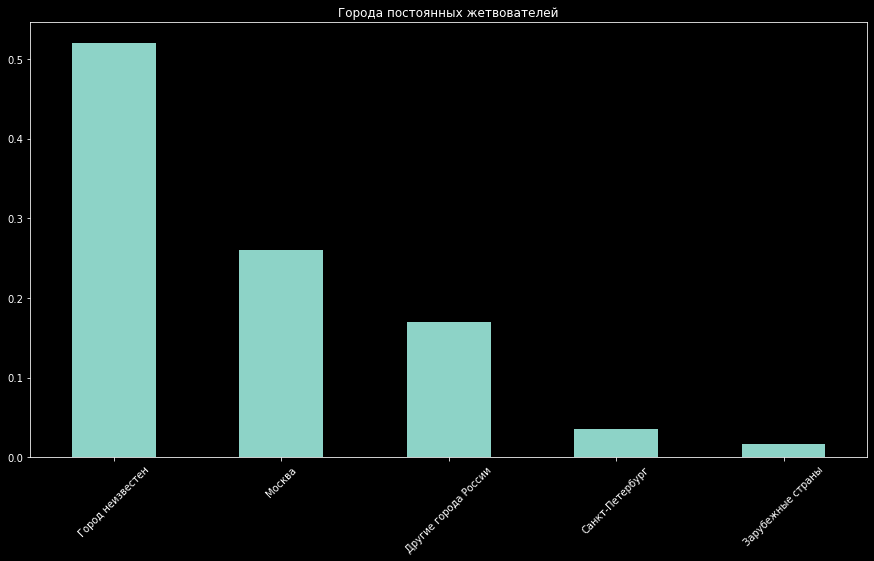

In [34]:
(df['city'].value_counts()/len(df['id'])).plot(
    title='Города постоянных жетвователей',
    kind='bar', 
    figsize=(15,8),
    rot=45
);

In [35]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [36]:
#df['day_year'] = pd.DatetimeIndex(df['date']).year
#df['last_email_activity_year'] = pd.DatetimeIndex(df['last_email_activity']).year
#df['day_month'] = pd.DatetimeIndex(df['date']).month
#df['last_email_activity_month'] = pd.DatetimeIndex(df['last_email_activity']).month

#добавляем столбец lifetime: дейсвие договора в месяцах
#df['lifetime'] = (df['last_email_activity_year'] - df['day_year']) * 365 + (df['last_email_activity_month']
#                - df['day_month']) * 30

#df.loc[df['lifetime'] == 0, 'lifetime'] = 1

In [37]:

# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные 
df['is_reccurent'] = df['is_reccurent'].replace('да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [38]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(30)

пожертвование                                                                     0.272397
пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"    0.237688
пожертвование  undefined                                                          0.154087
no_info                                                                           0.090443
добровольное пожертвование. ндс не облагается                                     0.035136
sms bdd                                                                           0.018032
пожертвование клуб друзей                                                         0.009051
на психологические консультации артёму                                            0.006201
пожертвование без назначения                                                      0.005131
пожертвование на обучение артёма                                                  0.004419
пожертвование на обучение александры                                              0.004205

In [39]:
df['purpose'].fillna('no_info', inplace=True)


df['purpose'] = (df['purpose']
                 .str
                 .replace('пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"', 'пожертвование')
                 .replace('пожертвование  undefined', 'пожертвование')
                 .replace('добровольное пожертвование. ндс не облагается', 'пожертвование')
                )

In [40]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(25)

пожертвование                                                                     0.272397
пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"    0.237688
пожертвование  undefined                                                          0.154087
no_info                                                                           0.090514
добровольное пожертвование. ндс не облагается                                     0.035136
sms bdd                                                                           0.018032
пожертвование клуб друзей                                                         0.009051
на психологические консультации артёму                                            0.006201
пожертвование без назначения                                                      0.005131
пожертвование на обучение артёма                                                  0.004419
пожертвование на обучение александры                                              0.004205

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   14031 non-null  object        
 1   date                 14031 non-null  datetime64[ns]
 2   amount               14031 non-null  float64       
 3   is_reccurent         14031 non-null  int64         
 4   purpose              14031 non-null  object        
 5   channel              14031 non-null  object        
 6   gender               14031 non-null  object        
 7   city                 14031 non-null  object        
 8   last_email_activity  11073 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [42]:

def purose_category(purpose):
    
    if 'на обучение' in purpose.loc['purpose']:
        return 'обучение'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'пожертвование' in purpose.loc['purpose']:
        return 'пожертвование'
    else:
        return 'на другие цели'


# применим функцию
df['purpose'] = df.apply(purose_category, axis=1)
df.head()


,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,2022-07-18 17:19:02
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,NaT
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,NaT
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-20 20:32:37


In [43]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(25)

пожертвование     0.772290
на другие цели    0.145749
обучение          0.063930
sms               0.018032
Name: purpose, dtype: float64

<AxesSubplot:title={'center':'Назначения платежей для постоянных жертвователей'}>

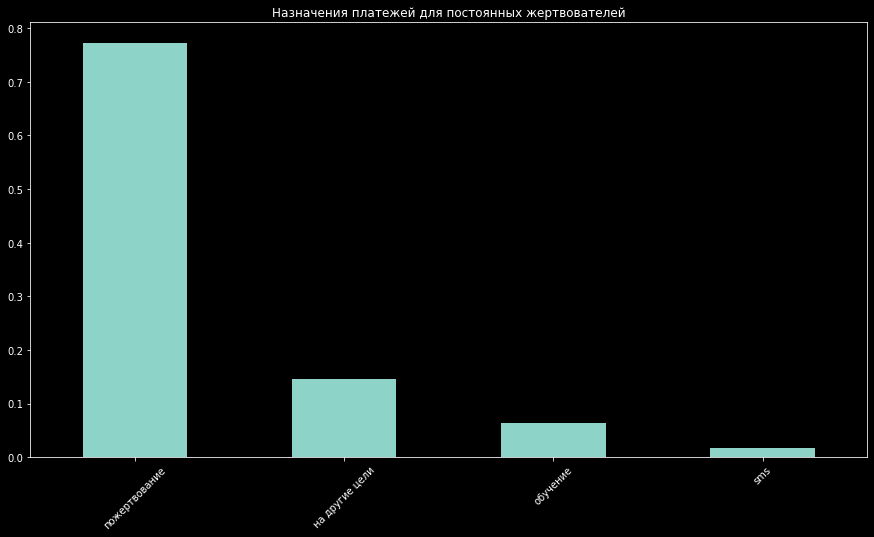

In [44]:
# Назначения платежей
(df['purpose'].value_counts()/len(df['id'])).plot(title='Назначения платежей для постоянных жертвователей',
    kind='bar',
    figsize=(15,8),
    rot=45)
 


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   14031 non-null  object        
 1   date                 14031 non-null  datetime64[ns]
 2   amount               14031 non-null  float64       
 3   is_reccurent         14031 non-null  int64         
 4   purpose              14031 non-null  object        
 5   channel              14031 non-null  object        
 6   gender               14031 non-null  object        
 7   city                 14031 non-null  object        
 8   last_email_activity  11073 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [46]:
df['date_day'] =df['date'].dt.day
df['date_month'] =df['date'].dt.month
df['date_year'] =df['date'].dt.year
df['last_email_activity_day'] = df['last_email_activity'].dt.day
df['last_email_activity_month'] = df['last_email_activity'].dt.month
df['last_email_activity_year'] = df['last_email_activity'].dt.year

In [47]:
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,3,7,2022,3.0,6.0,2022.0
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,2022-07-18 17:19:02,14,3,2020,18.0,7.0,2022.0
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,NaT,7,4,2022,NaN,NaN,NaN
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,12,2019,NaN,NaN,NaN
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-20 20:32:37,26,6,2021,20.0,7.0,2022.0


In [48]:
#df[df['id']=='29c903a6-ae15-40fc-81fa-4f58d06f3139']

In [49]:
#df[df['id']=='2c65d134-af3b-4a17-afce-72159c28da67']

<AxesSubplot:>

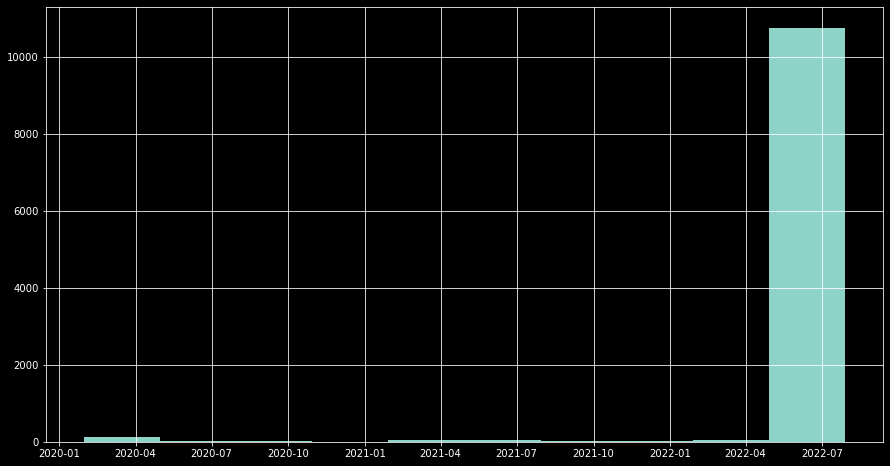

In [50]:
plt.figure(figsize=(15,8))
df['last_email_activity'].hist()

In [51]:
df = df.sort_values(['id', 'date'], ascending=[True, True])
df['life_time'] = df.groupby('id')['date'].apply(lambda x: x.diff().fillna(pd.Timedelta(1,'D')))#.cumsum())

In [52]:
df['life_time']=df['life_time'].dt.days

In [53]:
df[df['id']=='0f1e1fb0-6467-46c1-8126-4816c5e004f7'].sort_values(['date'], ascending=[True])

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
12970,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2020-11-25,62.48,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,25,11,2020,NaN,NaN,NaN,1
6800,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2020-12-11,62.50,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,11,12,2020,NaN,NaN,NaN,16
3998,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-01-14,52.26,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,14,1,2021,NaN,NaN,NaN,34
1510,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-06-28,8.65,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,28,6,2021,NaN,NaN,NaN,165
1563,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-06-29,6.68,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,29,6,2021,NaN,NaN,NaN,1
7577,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-01,6.64,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,1,7,2021,NaN,NaN,NaN,2
2192,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-06,8.92,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,6,7,2021,NaN,NaN,NaN,5
5631,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-10,6.92,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,10,7,2021,NaN,NaN,NaN,4
300,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-12,5.16,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,12,7,2021,NaN,NaN,NaN,2
12971,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-12-12,6.52,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,12,12,2021,NaN,NaN,NaN,153


In [54]:
df[df['id']=='de5393f9-9585-4057-b7fb-24b69697fc08'].sort_values(['date'], ascending=True)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
831,de5393f9-9585-4057-b7fb-24b69697fc08,2020-12-30 11:42:20,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,12,2020,3.0,6.0,2022.0,1
1552,de5393f9-9585-4057-b7fb-24b69697fc08,2020-12-30 11:54:50,300.0,0,на другие цели,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,12,2020,3.0,6.0,2022.0,0
7168,de5393f9-9585-4057-b7fb-24b69697fc08,2021-01-30 11:42:47,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,1,2021,3.0,6.0,2022.0,30
10505,de5393f9-9585-4057-b7fb-24b69697fc08,2021-02-28 11:42:35,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,28,2,2021,3.0,6.0,2022.0,28
3894,de5393f9-9585-4057-b7fb-24b69697fc08,2021-03-30 11:42:31,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,3,2021,3.0,6.0,2022.0,29
13348,de5393f9-9585-4057-b7fb-24b69697fc08,2021-04-30 11:42:41,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,4,2021,3.0,6.0,2022.0,31
6174,de5393f9-9585-4057-b7fb-24b69697fc08,2021-05-30 11:42:37,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,5,2021,3.0,6.0,2022.0,29
2442,de5393f9-9585-4057-b7fb-24b69697fc08,2021-06-30 11:42:51,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,6,2021,3.0,6.0,2022.0,31
13035,de5393f9-9585-4057-b7fb-24b69697fc08,2021-07-30 11:42:33,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,7,2021,3.0,6.0,2022.0,29
4495,de5393f9-9585-4057-b7fb-24b69697fc08,2021-08-30 12:45:51,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,8,2021,3.0,6.0,2022.0,31


In [55]:
df[df['id']=='0001afdd-94e3-48f3-b5e7-d5539700425e'].sort_values(['date'], ascending=True)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9904,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,4,2019,NaN,NaN,NaN,1


In [56]:
df.head(3)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9904,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,4,2019,NaN,NaN,NaN,1
13529,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1
1628,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-04-29 08:24:29,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,4,2020,27.0,7.0,2022.0,33


In [57]:
#df_count = df.groupby(['id'])['life_time'].agg(['count','sum']).sort_values(by='count', ascending=False)
#df_count

In [58]:
df_count = df.groupby('id')['amount'].count().to_frame().sort_values(by='amount', ascending=False)
df_count


,amount
id,
8a8daecd-40b3-4a41-b53c-06a62be672e6,83
0b6da68c-558b-4153-806e-b1d775585b88,76
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,76
85348172-f358-4345-91f1-db8cf0531c8a,73
4ecb767f-8830-497b-b395-851d4eacd1f8,65
...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1
62602f1f-b33b-4a10-a17a-aea4adb4791d,1


In [59]:
df_count['churn'] = 0
df_count.loc[df_count['amount']==1,'churn'] = 1
df_count

,amount,churn
id,,
8a8daecd-40b3-4a41-b53c-06a62be672e6,83,0
0b6da68c-558b-4153-806e-b1d775585b88,76,0
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,76,0
85348172-f358-4345-91f1-db8cf0531c8a,73,0
4ecb767f-8830-497b-b395-851d4eacd1f8,65,0
...,...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1,1
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1,1
62602f1f-b33b-4a10-a17a-aea4adb4791d,1,1


In [60]:
df_count= df_count.drop('amount', axis=1)
df_count

,churn
id,
8a8daecd-40b3-4a41-b53c-06a62be672e6,0
0b6da68c-558b-4153-806e-b1d775585b88,0
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,0
85348172-f358-4345-91f1-db8cf0531c8a,0
4ecb767f-8830-497b-b395-851d4eacd1f8,0
...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1
62602f1f-b33b-4a10-a17a-aea4adb4791d,1


In [61]:
df_new = df.merge(df_count, how='left', on = 'id')
df_new.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,4,2019,NaN,NaN,NaN,1,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1,0


In [62]:
df_new[df_new['id']=='4ecb767f-8830-497b-b395-851d4eacd1f8'].sort_values(['date'], ascending=True)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
4117,4ecb767f-8830-497b-b395-851d4eacd1f8,2016-12-25 21:36:52,1000.0,0,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,25,12,2016,18.0,7.0,2022.0,1,0
4118,4ecb767f-8830-497b-b395-851d4eacd1f8,2017-03-03 08:37:56,2000.0,0,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,3,3,2017,18.0,7.0,2022.0,67,0
4119,4ecb767f-8830-497b-b395-851d4eacd1f8,2017-05-21 20:41:40,1000.0,0,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,21,5,2017,18.0,7.0,2022.0,79,0
4120,4ecb767f-8830-497b-b395-851d4eacd1f8,2017-06-20 23:02:40,1000.0,0,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,20,6,2017,18.0,7.0,2022.0,30,0
4121,4ecb767f-8830-497b-b395-851d4eacd1f8,2017-07-14 09:39:56,1000.0,0,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,14,7,2017,18.0,7.0,2022.0,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,4ecb767f-8830-497b-b395-851d4eacd1f8,2022-03-16 15:45:04,1500.0,1,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,16,3,2022,18.0,7.0,2022.0,28,0
4178,4ecb767f-8830-497b-b395-851d4eacd1f8,2022-04-16 15:44:16,1500.0,1,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,16,4,2022,18.0,7.0,2022.0,30,0
4179,4ecb767f-8830-497b-b395-851d4eacd1f8,2022-05-16 12:54:24,2000.0,1,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,16,5,2022,18.0,7.0,2022.0,29,0
4180,4ecb767f-8830-497b-b395-851d4eacd1f8,2022-06-16 12:55:21,2000.0,1,пожертвование,банковские карты,мужской ...,другие города россии,2022-07-18 16:29:31,16,6,2022,18.0,7.0,2022.0,31,0


In [63]:
df_new[df_new['id']=='626c5441-75d2-45e9-bbc9-4502685f23bd'].sort_values(['date'], ascending=True)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
5081,626c5441-75d2-45e9-bbc9-4502685f23bd,2019-07-25 17:19:23,200.0,0,на другие цели,sms,no_info,город неизвестен,NaT,25,7,2019,NaN,NaN,NaN,1,1


In [64]:
for column in ['last_email_activity','last_email_activity_day', 'last_email_activity_month', 'last_email_activity_year']:            
    df_new[column].fillna(0, inplace=True)
df_new['purpose'].fillna('no_info', inplace=True)


In [65]:
df_new.isna().mean()

id                           0.0
date                         0.0
amount                       0.0
is_reccurent                 0.0
purpose                      0.0
channel                      0.0
gender                       0.0
city                         0.0
last_email_activity          0.0
date_day                     0.0
date_month                   0.0
date_year                    0.0
last_email_activity_day      0.0
last_email_activity_month    0.0
last_email_activity_year     0.0
life_time                    0.0
churn                        0.0
dtype: float64

In [66]:
df_new["amount"].describe().round()

count      14031.0
mean        1722.0
std        29512.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: amount, dtype: float64

In [67]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         14031 non-null  object        
 1   date                       14031 non-null  datetime64[ns]
 2   amount                     14031 non-null  float64       
 3   is_reccurent               14031 non-null  int64         
 4   purpose                    14031 non-null  object        
 5   channel                    14031 non-null  object        
 6   gender                     14031 non-null  object        
 7   city                       14031 non-null  object        
 8   last_email_activity        14031 non-null  object        
 9   date_day                   14031 non-null  int64         
 10  date_month                 14031 non-null  int64         
 11  date_year                  14031 non-null  int64         
 12  last

In [68]:
df_new.sample(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
10870,c39d76d6-a933-4d47-b625-e34df83b7403,2021-09-12 10:48:48,500.0,1,пожертвование,банковские карты,женский ...,москва,2022-07-18 16:29:47,12,9,2021,18.0,7.0,2022.0,84,0
13552,f726e7c0-e8c5-4264-9f8f-58c8bcac73b6,2022-05-01 12:57:42,1000.0,1,пожертвование,банковские карты,женский ...,москва,2022-07-18 16:29:47,1,5,2022,18.0,7.0,2022.0,29,0


# Исследовательский анализ данных

# amount

In [69]:
df_new['amount'].describe().T.round(3)

count      14031.000
mean        1722.305
std        29512.340
min            0.010
25%          150.000
50%          350.000
75%          700.000
max      3000000.000
Name: amount, dtype: float64

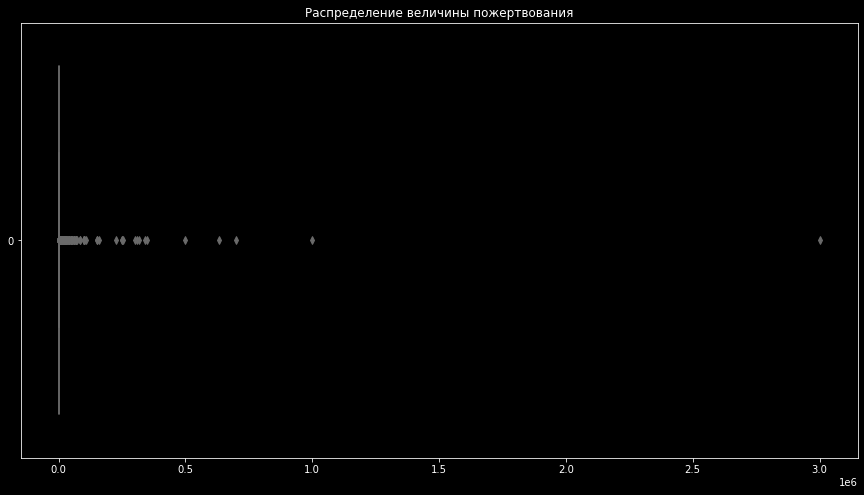

In [70]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_new['amount'], orient = 'h')
plt.title('Распределение величины пожертвования')
plt.show()

In [71]:

df_sum_count = df_new.groupby(['id','is_reccurent'])['amount'].agg(['count','sum', 'mean', 'median']).sort_values(by='sum', ascending=False)
df_sum_count

,,count,sum,mean,median
id,is_reccurent,,,,
29c903a6-ae15-40fc-81fa-4f58d06f3139,0,1,3000000.00,3.000000e+06,3000000.00
99a56103-5bdb-4c2b-af08-0ef1a3d4dc37,0,29,2134289.00,7.359617e+04,200.00
99d83c2d-f72a-4c58-9641-782996644f81,0,1,1000000.00,1.000000e+06,1000000.00
4a6e53ad-4134-499f-8fa5-fbbea120687a,0,8,699800.00,8.747500e+04,6750.00
6ec0197e-4a86-47b6-a3ed-d9b6981bd4fe,0,1,500000.00,5.000000e+05,500000.00
...,...,...,...,...,...
420cc3d4-1252-43ad-9d07-5b8d08f37d01,0,1,0.48,4.800000e-01,0.48
fc1eb8bd-b30f-47a8-b347-0200183861d8,0,1,0.22,2.200000e-01,0.22
b0b6eb05-ac83-4772-a2be-89901bca336f,0,1,0.01,1.000000e-02,0.01


In [72]:
df_sum_count =df_sum_count [['count','sum']]

In [73]:
from sklearn.ensemble import IsolationForest
df_sum_count =df_sum_count [['count','sum']]

isolation_forest = IsolationForest(n_estimators=100) # < напишите код здесь >
sales = df_sum_count['count'].values.reshape(-1, 1) 
isolation_forest.fit(df_sum_count) 
anomaly_scores = isolation_forest.decision_function(df_sum_count)
estimator = isolation_forest.fit_predict(df_sum_count)
outliers = [e for e in estimator if e == -1]
print("Количество аномалий: ", len(outliers))


Количество аномалий:  600


In [74]:

x = df_sum_count.loc[:,['count','sum']].values

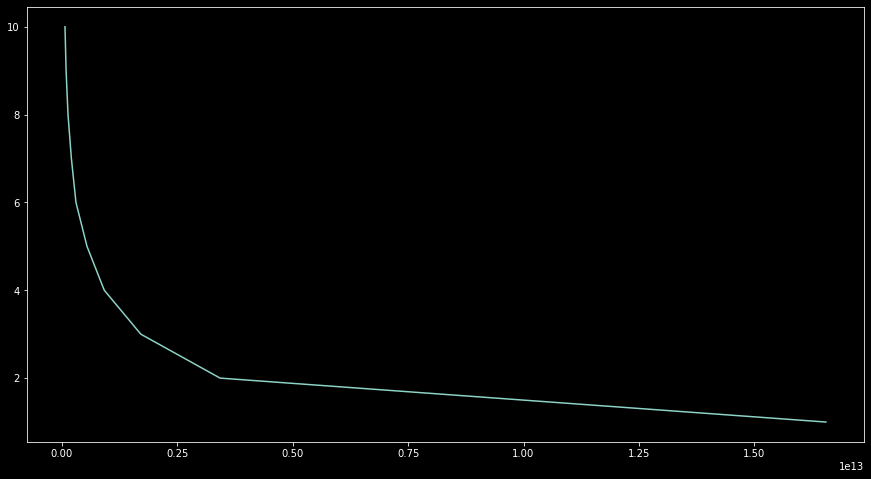

In [75]:
from sklearn.cluster import KMeans
plt.figure(figsize=(15,8))
distortion = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++').fit(x)
    
    distortion.append(kmeans.inertia_)
plt.plot(distortion, range(1,11))

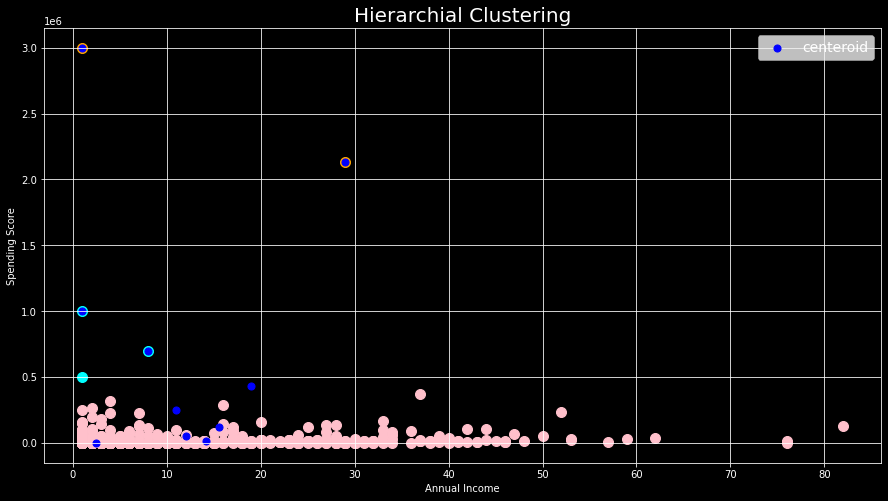

In [76]:
from sklearn.cluster import AgglomerativeClustering

hc_model = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc_model.fit_predict(x)
plt.figure(figsize=(15,8))
plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 100, c = 'pink', label = '')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 100, c = 'orange', label = '')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 100, c = 'cyan', label = '')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

In [77]:
df_new.groupby('id')['amount'].agg(['count','sum', 'mean', 'median']).sort_values(by='count', ascending=False)

,count,sum,mean,median
id,,,,
8a8daecd-40b3-4a41-b53c-06a62be672e6,83,129500.0,1560.240964,1000.0
0b6da68c-558b-4153-806e-b1d775585b88,76,13500.0,177.631579,200.0
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,76,2280.0,30.000000,30.0
85348172-f358-4345-91f1-db8cf0531c8a,73,17202.0,235.643836,100.0
4ecb767f-8830-497b-b395-851d4eacd1f8,65,93500.0,1438.461538,1500.0
...,...,...,...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1,100.0,100.000000,100.0
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1,500.0,500.000000,500.0
62602f1f-b33b-4a10-a17a-aea4adb4791d,1,300.0,300.000000,300.0


In [78]:
# посмотрим соотношение между городом и общей суммой пожертвований

city_total_sum = df.groupby('city', as_index=False)['amount'].agg(['count','sum', 'mean', 'median'])
city_total_sum = city_total_sum.sort_values(by='sum', ascending=False)
city_total_sum

,count,sum,mean,median
city,,,,
москва,3643,11878614.00,3260.668131,500.0
город неизвестен,7294,9078598.01,1244.666577,300.0
другие города россии,2374,2147334.49,904.521689,300.0
санкт-петербург,494,815789.16,1651.395061,300.0
зарубежные страны,226,245325.00,1085.508850,1000.0


In [79]:
gender_sum = df_new.groupby('gender')['amount'].agg(['count','sum', 'mean', 'median','std'])
gender_sum

,count,sum,mean,median,std
gender,,,,,
no_info,1569,874724.00,557.504143,200.0,2965.723279
женский,9674,14296757.10,1477.853742,300.0,17513.587634
мужской,2788,8994179.56,3226.032841,500.0,57548.481610


In [80]:
gender_sum = df_new.groupby(['channel','gender'])['amount'].agg(['count','sum', 'mean', 'median','std'])
gender_sum

count  \
channel                      gender                                                      
sms                          no_info                                              1266   
                             женский                                        ...    190   
                             мужской                                        ...     18   
банковские карты             no_info                                               302   
                             женский                                        ...   8612   
                             мужской                                        ...   2290   
наличные в кассу             женский                                        ...      3   
прямые поступления на счет   no_info                                                 1   
                             женский                                        ...    869   
                             мужской                                        ...    480   

                                                                                        sum  \
channel                      gender                                                           
sms                          no_info                                              350953.00   
                             женский                                        ...    41286.00   
                             мужской                                        ...     5500.00   
банковские карты             no_info                                              523671.00   
                             женский                                        ...  8135989.15   
                             мужской                                        ...  4870450.63   
наличные в кассу             женский                                        ...  1110700.00   
прямые поступления на счет   no_info                                                 100.00   
                             женский                                        ...  5008781.95   
                             мужской                                        ...  4118228.93   

                                                                                          mean  \
channel                      gender                                                              
sms                          no_info                                                277.214060   
                             женский                                        ...     217.294737   
                             мужской                                        ...     305.555556   
банковские карты             no_info                                               1734.009934   
                             женский                                        ...     944.727026   
                             мужской                                        ...    2126.834336   
наличные в кассу             женский                                        ...  370233.333333   
прямые поступления на счет   no_info                                                100.000000   
                             женский                                        ...    5763.845742   
                             мужской                                        ...    8579.643604   

                                                                                   median  \
channel                      gender                                                         
sms                          no_info                                                200.0   
                             женский                                        ...     200.0   
                             мужской                                        ...     300.0   
банковские карты             no_info                                                500.0   
                             женский                                        ...     350.0   
                             му

In [81]:
df_new.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity', 'date_day', 'date_month', 'date_year',
       'last_email_activity_day', 'last_email_activity_month',
       'last_email_activity_year', 'life_time', 'churn'],
      dtype='object')

In [82]:
reccurent_total_sum = df_new.groupby(['is_reccurent','gender'])['amount'].agg(['count','sum', 'mean', 'median','std'])
reccurent_total_sum

count  \
is_reccurent gender                                                      
0            no_info                                              1418   
             женский                                        ...   3443   
             мужской                                        ...   1085   
1            no_info                                               151   
             женский                                        ...   6231   
             мужской                                        ...   1703   

                                                                         sum  \
is_reccurent gender                                                            
0            no_info                                               724724.00   
             женский                                        ...  10508765.10   
             мужской                                        ...   7074375.56   
1            no_info                                               150000.00   
             женский                                        ...   3787992.00   
             мужской                                        ...   1919804.00   

                                                                        mean  \
is_reccurent gender                                                            
0            no_info                                              511.088858   
             женский                                        ...  3052.211763   
             мужской                                        ...  6520.161806   
1            no_info                                              993.377483   
             женский                                        ...   607.926818   
             мужской                                        ...  1127.307105   

                                                                 median  \
is_reccurent gender                                                       
0            no_info                                              200.0   
             женский                                        ...   450.0   
             мужской                                        ...   500.0   
1            no_info                                              300.0   
             женский                                        ...   300.0   
             мужской                                        ...   500.0   

                                                                          std  
is_reccurent gender                                                            
0            no_info                                              3076.383021  
             женский                                        ...  29245.946223  
             мужской                                        ...  92159.802361  
1            no_info                                              1525.228677  
             женский                                        ...   1246.438882  
             мужской                                        ...   1516.054726

In [83]:
id_sum = df_new.groupby(['id'])['amount'].agg(['count','sum', 'mean', 'median','std'])
id_sum

,count,sum,mean,median,std
id,,,,,
0001afdd-94e3-48f3-b5e7-d5539700425e,1,100.0,100.000000,100.0,NaN
000711b2-2785-461b-bf5b-5cb7d2caba20,21,10500.0,500.000000,500.0,0.000000
0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2,400.0,200.000000,200.0,0.000000
002cb994-10cd-45e9-b6ed-ed7f3c90d7a9,1,1000.0,1000.000000,1000.0,NaN
006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,1,200.0,200.000000,200.0,NaN
...,...,...,...,...,...
ff946fd1-eef8-4541-a906-bae64527aaa5,1,50.0,50.000000,50.0,NaN
ffa30123-a516-44a7-b030-f83ed369b645,27,4100.0,151.851852,200.0,50.917508
ffb1c4fa-f950-4bb7-a1f2-9dd655298fff,1,100.0,100.000000,100.0,NaN


In [84]:
id_life_time_sum = df_new.groupby(['id'])['is_reccurent','life_time'].agg(['count','sum'])
id_life_time_sum

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


is_reccurent     life_time     
                                            count sum     count  sum
id                                                                  
0001afdd-94e3-48f3-b5e7-d5539700425e            1   0         1    1
000711b2-2785-461b-bf5b-5cb7d2caba20           21  21        21  814
0015a100-2d8c-4262-a9b3-bb1461c0c8b8            2   0         2    1
002cb994-10cd-45e9-b6ed-ed7f3c90d7a9            1   0         1    1
006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a            1   0         1    1
...                                           ...  ..       ...  ...
ff946fd1-eef8-4541-a906-bae64527aaa5            1   0         1    1
ffa30123-a516-44a7-b030-f83ed369b645           27  26        27  819
ffb1c4fa-f950-4bb7-a1f2-9dd655298fff            1   0         1    1
ffccba23-89ca-4a22-bd8a-7cad2d9eb7f7            3   0         3   22
ffebaa14-fde5-4a6d-9363-fe84a18d68bc            1   0         1    1

[3683 rows x 4 columns]

In [85]:
life_time_sum = df_new.groupby(['life_time'])['amount'].agg(['count','sum', 'mean', 'median','std'])
life_time_sum

,count,sum,mean,median,std
life_time,,,,,
0,452,1071952.30,2371.575885,500.000,5678.042069
1,3793,11543833.04,3043.457168,300.000,53240.741511
2,42,324121.01,7717.166905,177.005,47766.895615
3,46,19093.56,415.077391,300.000,488.208939
4,49,21273.92,434.161633,100.000,997.497755
...,...,...,...,...,...
1560,1,1000.00,1000.000000,1000.000,NaN
1596,1,1000.00,1000.000000,1000.000,NaN
1610,1,5000.00,5000.000000,5000.000,NaN


In [86]:
df_new['date']

0       2019-04-26 19:19:24
1       2020-03-27 08:23:58
2       2020-04-29 08:24:29
3       2020-05-28 08:24:10
4       2020-07-27 08:24:02
                ...        
14026   2019-04-26 20:37:02
14027   2021-08-29 00:00:00
14028   2021-09-13 00:00:00
14029   2021-09-19 00:00:00
14030   2017-04-14 21:28:03
Name: date, Length: 14031, dtype: datetime64[ns]

In [87]:
df_new['date'].sort_index(inplace=True)

In [88]:

df_new['date'].index.is_monotonic


True

<AxesSubplot:>

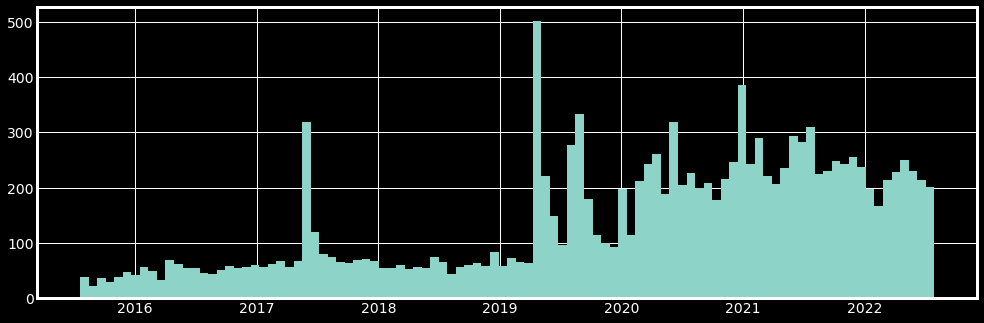

In [89]:
plt.style.use('dark_background')
df_new['date'].hist(figsize = (15, 5), bins=100)

In [90]:
df_year = df_new[df_new['date'].between('2019-01-01 00:00:00', '2022-07-01 00:00:00')]

<AxesSubplot:>

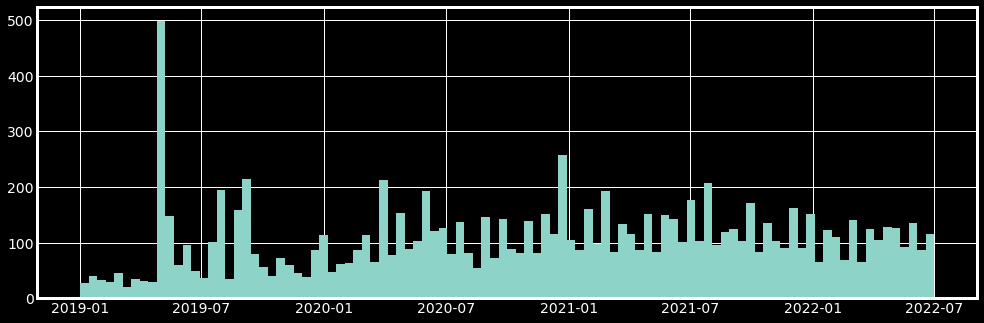

In [91]:
df_year['date'].hist(figsize = (15, 5), bins=100)

In [92]:
df_new.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,0,26,4,2019,0.0,0.0,0.0,1,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1,0
2,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-04-29 08:24:29,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,4,2020,27.0,7.0,2022.0,33,0
3,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-05-28 08:24:10,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,28,5,2020,27.0,7.0,2022.0,28,0
4,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-07-27 08:24:02,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,7,2020,27.0,7.0,2022.0,59,0


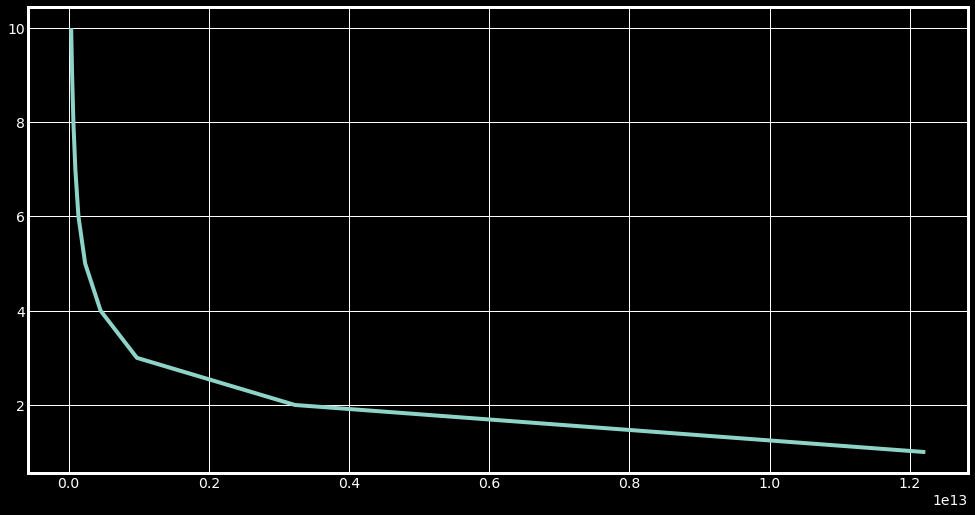

In [93]:
x = df_new.loc[:,['amount','is_reccurent', 'life_time']].values

from sklearn.cluster import KMeans
plt.figure(figsize=(15,8))
distortion = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++').fit(x)
    
    distortion.append(kmeans.inertia_)
plt.plot(distortion, range(1,11))


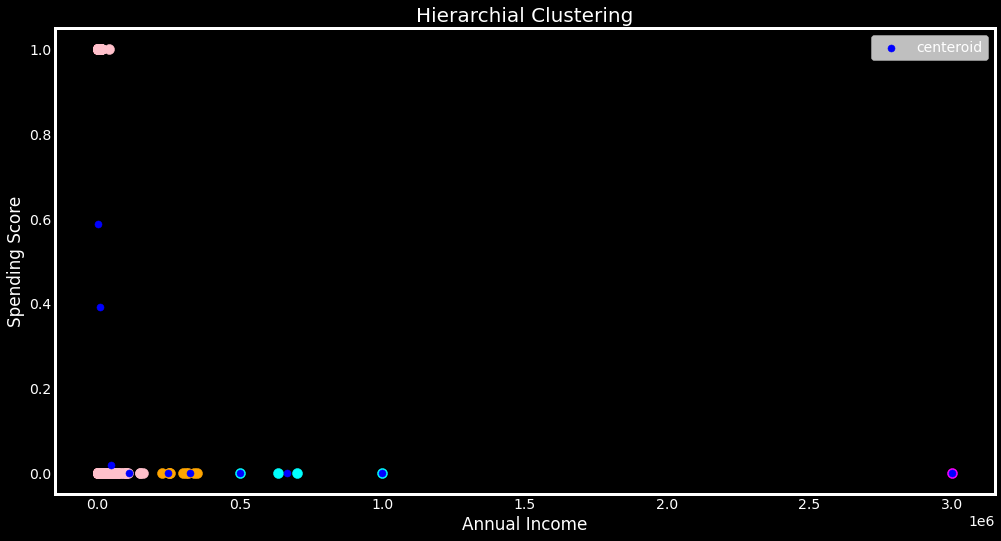

In [94]:
from sklearn.cluster import AgglomerativeClustering

hc_model = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc_model.fit_predict(x)
plt.figure(figsize=(15,8))
plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 100, c = 'pink', label = '')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 100, c = 'orange', label = '')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 100, c = 'cyan', label = '')
plt.scatter(x[y_hc == 3, 0], x[y_hc == 3, 1], s = 100, c = 'magenta', label = '')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

In [95]:
df_new['churn'].value_counts(normalize=True)

0    0.81156
1    0.18844
Name: churn, dtype: float64

In [96]:
#df = df.query('amount >150 and is_reccurent ==0')

#  Модель CatBoostClassifier

In [97]:

train = df_new[df_new['date'].between('2019-01-01 00:00:00', '2022-05-31 00:00:00')]
test = df_new[df_new['date'].between('2022-06-01 00:00:00', '2022-07-01 00:00:00')]

In [98]:
df_year.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity', 'date_day', 'date_month', 'date_year',
       'last_email_activity_day', 'last_email_activity_month',
       'last_email_activity_year', 'life_time', 'churn'],
      dtype='object')

In [99]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df_new = df_new.drop(['id', 'date', 'last_email_activity'], axis=1)



In [100]:
# список призноков
X = [ 'purpose', 'channel', 'gender', 'city','amount', 'is_reccurent',
      'date_day', 'date_month', 'date_year', 'last_email_activity_day',
      'last_email_activity_month','last_email_activity_year', 'life_time']
      
# список целевого признака

y=['churn']

#список категориальных признаков
cat_features =['purpose', 'channel', 'gender', 'city']
       

In [101]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.001,
          'random_seed': 42,
          'verbose':50,
          'iterations': 1500}

In [102]:

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [103]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    shuffle=False)

Training on fold [0/5]

bestTest = 0.9834804795
bestIteration = 874

Training on fold [1/5]

bestTest = 0.9856764321
bestIteration = 1438

Training on fold [2/5]

bestTest = 0.9853764731
bestIteration = 1336

Training on fold [3/5]

bestTest = 0.9848032494
bestIteration = 1458

Training on fold [4/5]

bestTest = 0.9874691611
bestIteration = 1058



In [104]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.972211,0.007076,0.690384,0.000049,0.690375,0.000020
1,1,0.976586,0.005132,0.687473,0.000171,0.687441,0.000087
2,2,0.978694,0.003327,0.684618,0.000232,0.684580,0.000099
3,3,0.978827,0.003150,0.681882,0.000197,0.681827,0.000045
4,4,0.979178,0.003403,0.679091,0.000230,0.679016,0.000056
...,...,...,...,...,...,...,...
1495,1495,0.985283,0.001523,0.120293,0.006123,0.117002,0.002186
1496,1496,0.985283,0.001522,0.120284,0.006124,0.116991,0.002185
1497,1497,0.985284,0.001522,0.120276,0.006124,0.116978,0.002184
1498,1498,0.985285,0.001522,0.120264,0.006123,0.116964,0.002185


In [105]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1443,1443,0.98529,0.001508,0.120953,0.006043,0.117771,0.002189


In [106]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          #'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'random_seed': 12345,
          'verbose':100,
          'iterations': 1495}



In [107]:
model = CatBoostClassifier(**params)

In [108]:
plt.style.use('dark_background')
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 12.1ms	remaining: 18.1s
100:	total: 709ms	remaining: 9.79s
200:	total: 1.43s	remaining: 9.21s
300:	total: 2.13s	remaining: 8.43s
400:	total: 2.98s	remaining: 8.12s
500:	total: 3.78s	remaining: 7.5s
600:	total: 4.61s	remaining: 6.85s
700:	total: 5.61s	remaining: 6.35s
800:	total: 6.56s	remaining: 5.68s
900:	total: 7.39s	remaining: 4.87s
1000:	total: 8.6s	remaining: 4.25s
1100:	total: 9.39s	remaining: 3.36s
1200:	total: 10.2s	remaining: 2.51s
1300:	total: 11s	remaining: 1.65s
1400:	total: 11.9s	remaining: 798ms
1494:	total: 12.7s	remaining: 0us


In [109]:
roc_auc_cat = roc_auc_score(test[y], model.predict_proba(test[X])[:, 1])
print(f"Accuracy на тестовой выборке : {(model.score(test[X], test[y])):.2f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.3f}")

Accuracy на тестовой выборке : 0.98
ROC_AUC для модели CatBoost на тестовой выборке: 0.987


In [110]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)



,Feature Id,Importances
0,life_time,69.741815
1,is_reccurent,7.837044
2,city,4.682815
3,date_year,3.483250
4,gender,2.515475
5,date_month,2.309168
6,channel,2.050108
7,amount,1.588282
8,date_day,1.549817
9,purpose,1.318399


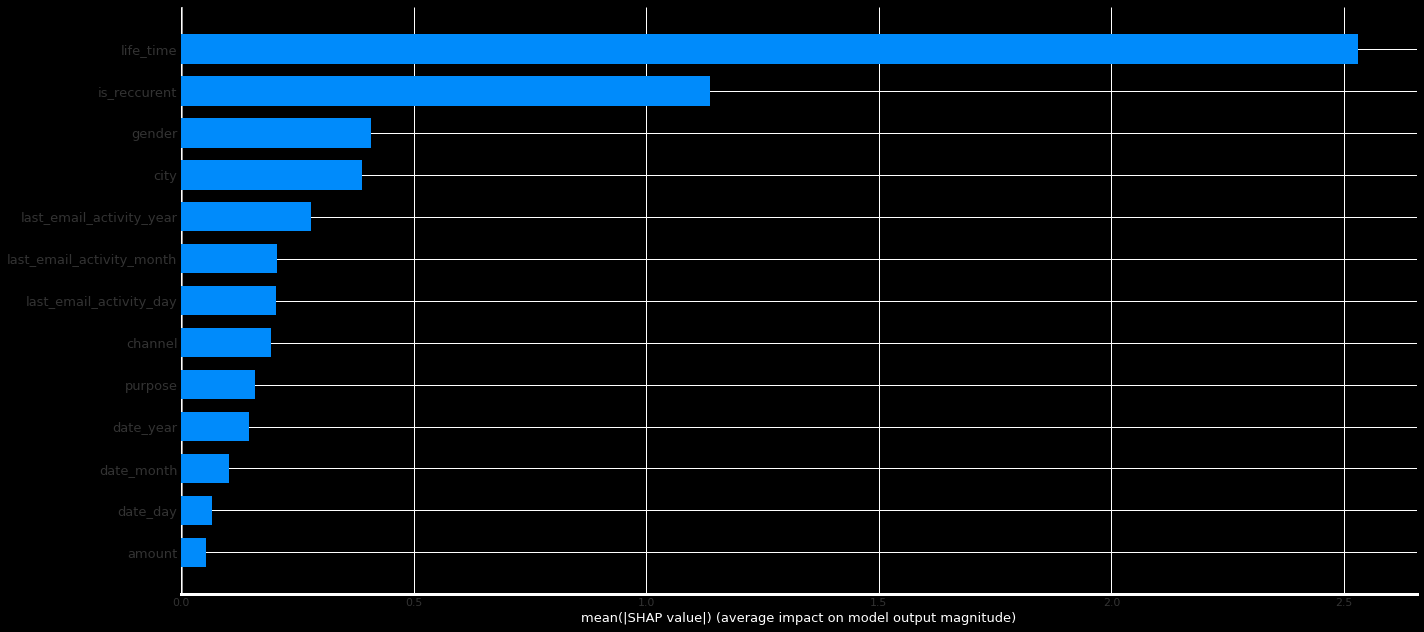

In [111]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

In [112]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете

shap.force_plot(explainer.expected_value, shap_values, test[X])

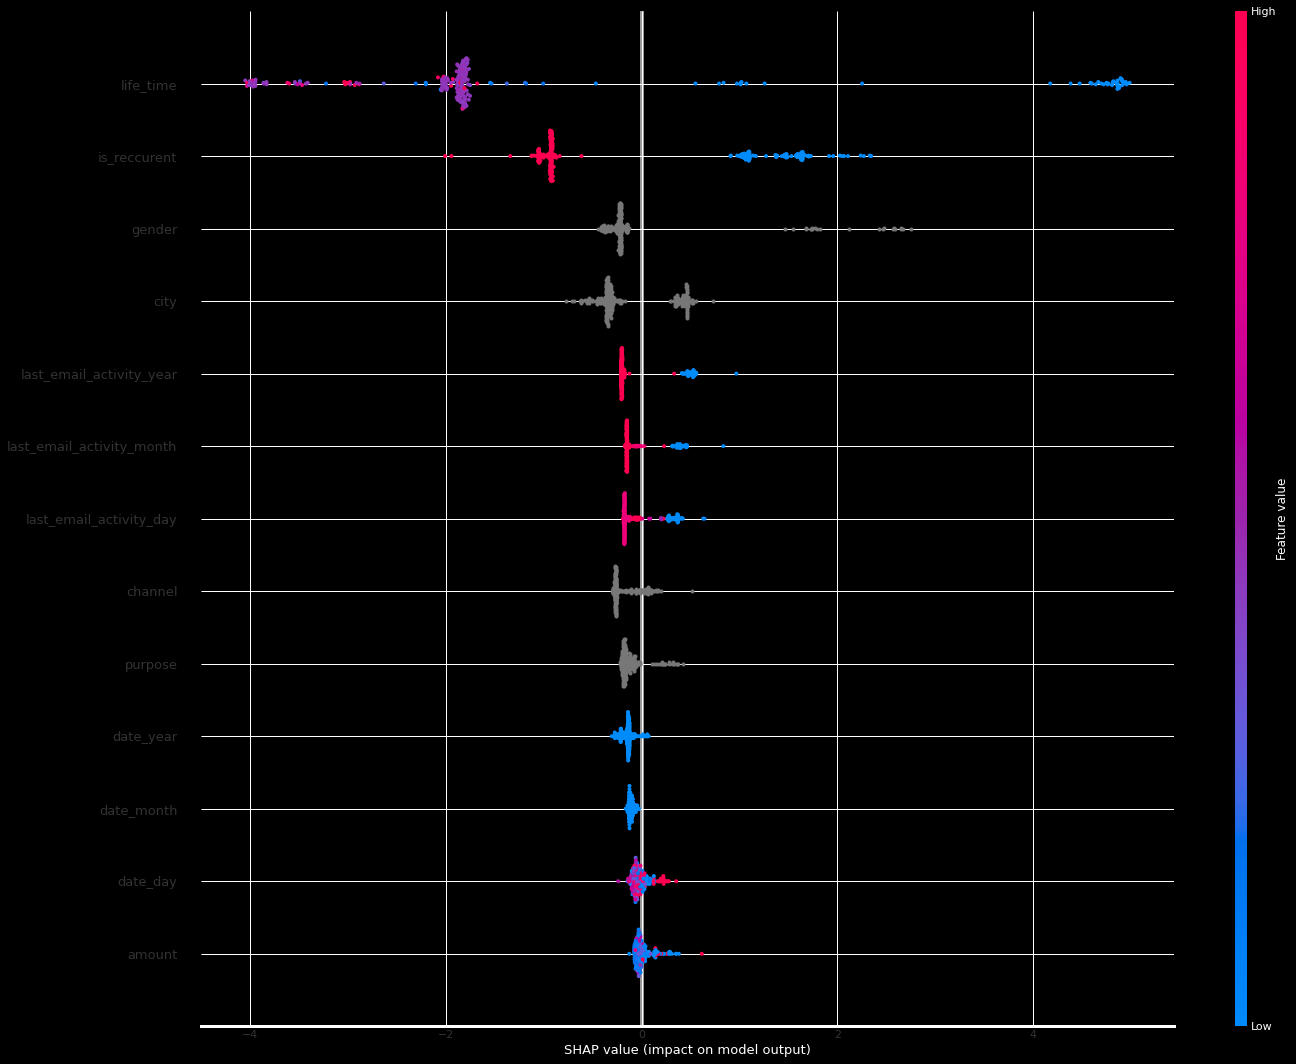

In [113]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(20,15))

In [114]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

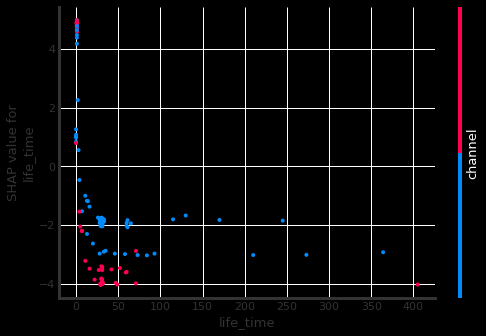

In [115]:
shap.dependence_plot('life_time', shap_values, test[X])

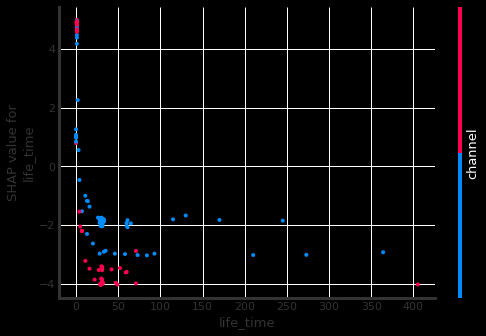

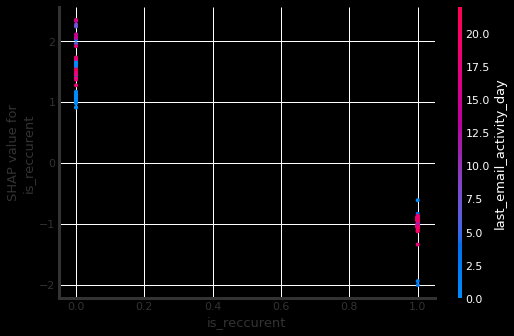

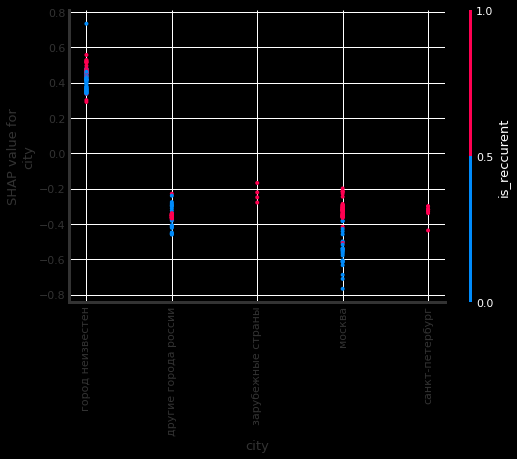

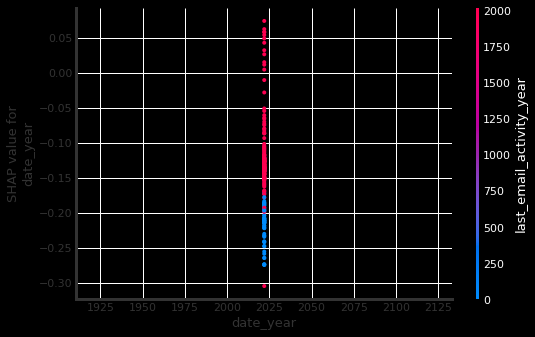

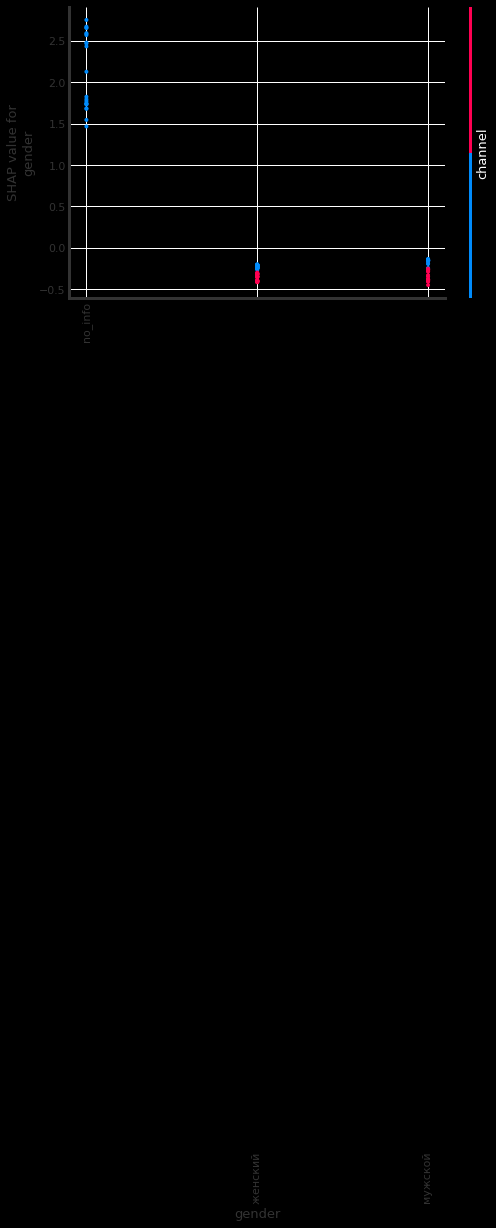

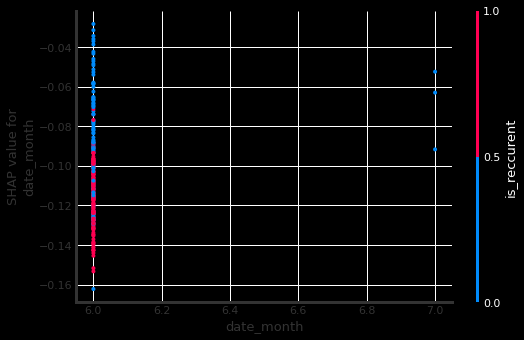

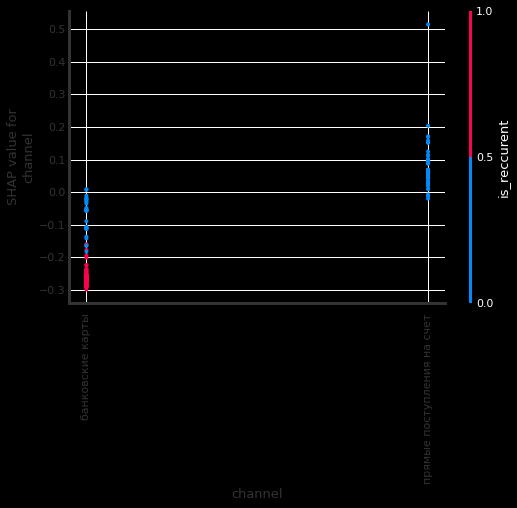

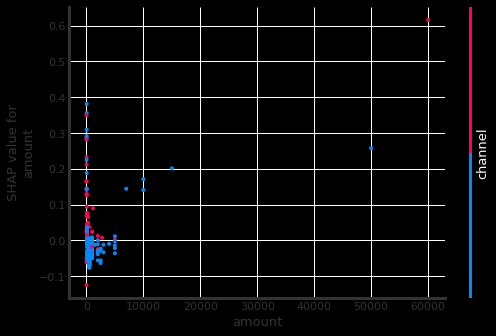

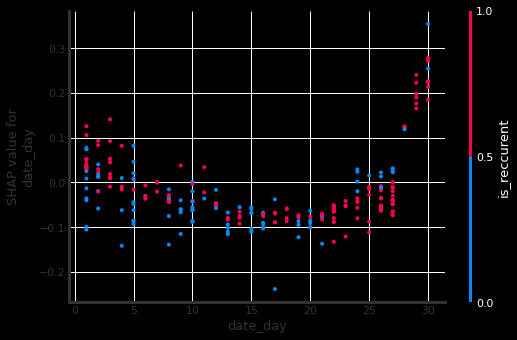

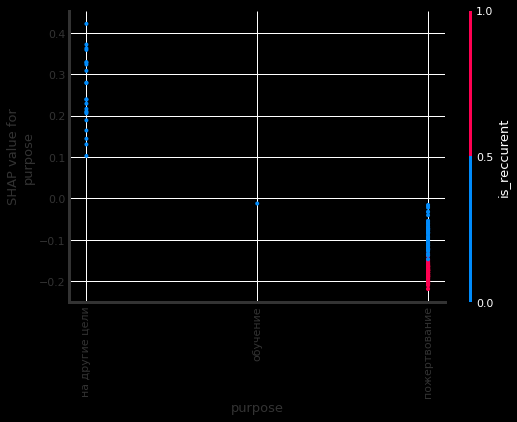

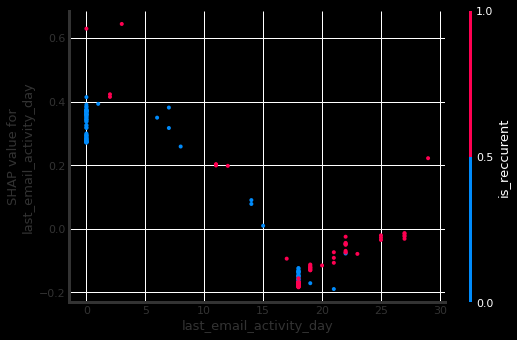

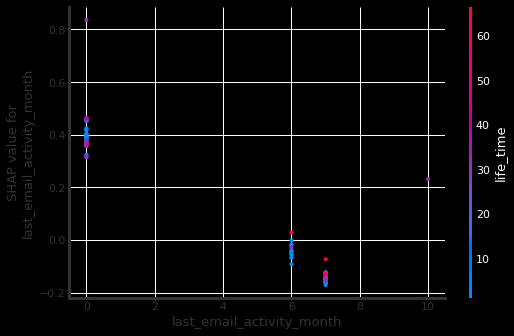

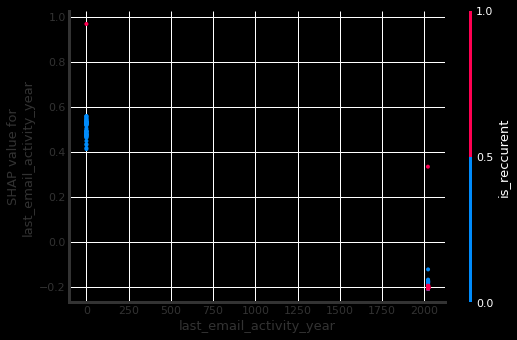

In [116]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

# CatBoostRegressor

In [117]:
lags = []
for lag in tqdm(lags):
    df_year["lag_" + str(lag)] = df_year.groupby("id")["amount"].shift(lag)

0it [00:00, ?it/s]


In [118]:
means = []
for mns in tqdm(means):
    df_year['rolling_median_'+str(mns)] = df_year.groupby(['id'])['amount'].transform(lambda x: x.rolling(mns).median())

0it [00:00, ?it/s]


In [119]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10713 entries, 0 to 14029
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         10713 non-null  object        
 1   date                       10713 non-null  datetime64[ns]
 2   amount                     10713 non-null  float64       
 3   is_reccurent               10713 non-null  int64         
 4   purpose                    10713 non-null  object        
 5   channel                    10713 non-null  object        
 6   gender                     10713 non-null  object        
 7   city                       10713 non-null  object        
 8   last_email_activity        10713 non-null  object        
 9   date_day                   10713 non-null  int64         
 10  date_month                 10713 non-null  int64         
 11  date_year                  10713 non-null  int64         
 12  last

In [120]:
#df = df.dropna()
df_year.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,0,26,4,2019,0.0,0.0,0.0,1,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1,0
2,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-04-29 08:24:29,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,4,2020,27.0,7.0,2022.0,33,0
3,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-05-28 08:24:10,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,28,5,2020,27.0,7.0,2022.0,28,0
4,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-07-27 08:24:02,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,7,2020,27.0,7.0,2022.0,59,0


In [121]:
  
train = df_year[df_year['date']<='2022-05-31 00:00:00']
test = df_year[df_year['date']>'2022-05-31 00:00:00']

In [122]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df_year=df_year.drop(['id', 'date', 'last_email_activity'], axis=1)


In [123]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print(train.shape)
print(test.shape)


0 14029
21 14024
(10455, 17)
(258, 17)


In [124]:
train.shape

(10455, 17)

In [125]:
test.shape

(258, 17)

In [126]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10713 entries, 0 to 14029
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount                     10713 non-null  float64
 1   is_reccurent               10713 non-null  int64  
 2   purpose                    10713 non-null  object 
 3   channel                    10713 non-null  object 
 4   gender                     10713 non-null  object 
 5   city                       10713 non-null  object 
 6   date_day                   10713 non-null  int64  
 7   date_month                 10713 non-null  int64  
 8   date_year                  10713 non-null  int64  
 9   last_email_activity_day    10713 non-null  float64
 10  last_email_activity_month  10713 non-null  float64
 11  last_email_activity_year   10713 non-null  float64
 12  life_time                  10713 non-null  int64  
 13  churn                      10713 non-null  int

In [127]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10455 entries, 0 to 14029
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         10455 non-null  object        
 1   date                       10455 non-null  datetime64[ns]
 2   amount                     10455 non-null  float64       
 3   is_reccurent               10455 non-null  int64         
 4   purpose                    10455 non-null  object        
 5   channel                    10455 non-null  object        
 6   gender                     10455 non-null  object        
 7   city                       10455 non-null  object        
 8   last_email_activity        10455 non-null  object        
 9   date_day                   10455 non-null  int64         
 10  date_month                 10455 non-null  int64         
 11  date_year                  10455 non-null  int64         
 12  last

In [128]:
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity', 'date_day', 'date_month', 'date_year',
       'last_email_activity_day', 'last_email_activity_month',
       'last_email_activity_year', 'life_time'],
      dtype='object')

In [129]:
# список призноков
X = ['is_reccurent', 'purpose', 'channel', 'gender', 'city',
       'date_day', 'date_month', 'date_year', 'last_email_activity_day',
       'last_email_activity_month','last_email_activity_year', 'life_time']#'lag_6',
      #'rolling_median_14', 'rolling_median_7',#'lag_14','lag_11','lag_28',
      #, 'lag_42', 'lag_49', 'lag_56',
     #'rolling_median_7',
     #'rolling_median_14',
     #'rolling_median_28']
       
# список целевого признака

y=['amount']

#список категориальных признаков
cat_features =['is_reccurent', 'purpose', 'channel', 'gender', 'city']
       

In [130]:
params={'loss_function':'RMSE',
       'cat_features':cat_features,
       'random_state':42,
       'iterations':2000,
       #'learning_rate': 0.01,
       'depth':  2,
       'verbose':50}



In [131]:


train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [132]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=100,
    fold_count=5,
    shuffle=False)

Training on fold [0/5]
0:	learn: 19010.5632961	test: 66232.8174498	best: 66232.8174498 (0)	total: 5.38ms	remaining: 10.7s
100:	learn: 17452.3614659	test: 66181.1311983	best: 66181.0427457 (98)	total: 337ms	remaining: 6.34s
200:	learn: 17034.3947202	test: 66181.4518387	best: 66176.5344687 (161)	total: 605ms	remaining: 5.41s
300:	learn: 16865.5994473	test: 66101.4750350	best: 66101.4087294 (299)	total: 927ms	remaining: 5.23s
400:	learn: 16757.7044886	test: 66000.0394978	best: 65999.1030741 (397)	total: 1.22s	remaining: 4.87s
500:	learn: 16694.6967172	test: 65940.6386867	best: 65940.5900009 (497)	total: 1.37s	remaining: 4.1s
600:	learn: 16659.1963592	test: 65941.4836357	best: 65936.0165272 (529)	total: 1.53s	remaining: 3.56s
700:	learn: 16563.9440293	test: 65840.9537107	best: 65839.4696197 (694)	total: 1.69s	remaining: 3.13s
800:	learn: 16502.6422493	test: 65793.2622455	best: 65792.6590915 (772)	total: 1.85s	remaining: 2.77s
900:	learn: 16445.1601363	test: 65762.1974952	best: 65762.193312

1700:	learn: 35258.3352616	test: 8776.3382053	best: 8546.0831238 (588)	total: 3.38s	remaining: 594ms
1800:	learn: 35210.2494769	test: 8806.9428184	best: 8546.0831238 (588)	total: 3.53s	remaining: 390ms
1900:	learn: 35160.0062855	test: 8837.8674816	best: 8546.0831238 (588)	total: 3.7s	remaining: 193ms
1999:	learn: 35137.8885553	test: 8846.7213509	best: 8546.0831238 (588)	total: 3.99s	remaining: 0us

bestTest = 8546.083124
bestIteration = 588

Training on fold [4/5]
0:	learn: 38010.0948812	test: 7286.2622522	best: 7286.2622522 (0)	total: 5.7ms	remaining: 11.4s
100:	learn: 37258.3745955	test: 7195.6986707	best: 7171.8189667 (34)	total: 170ms	remaining: 3.19s
200:	learn: 37103.5120136	test: 7182.9337213	best: 7171.8189667 (34)	total: 342ms	remaining: 3.06s
300:	learn: 36940.1306431	test: 7167.7648021	best: 7164.6668407 (243)	total: 491ms	remaining: 2.77s
400:	learn: 36866.7372525	test: 7164.8485616	best: 7160.8268220 (370)	total: 758ms	remaining: 3.02s
500:	learn: 36805.5210103	test: 7126.

In [133]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,26060.322200,24710.047627,33367.085049,8160.722495
1,1,26046.570104,24711.369924,33344.228226,8165.202931
2,2,26041.270315,24713.751509,33322.530809,8174.198601
3,3,26035.046545,24715.770314,33303.407006,8180.242208
4,4,26030.244264,24717.774828,33286.374780,8186.386570
...,...,...,...,...,...
1995,1995,29153.179637,23423.074413,30288.007963,8137.408579
1996,1996,29153.356767,23423.067933,30287.884179,8137.401701
1997,1997,29153.434696,23423.008960,30287.762564,8137.635563
1998,1998,29152.900213,23422.852731,30287.047862,8137.509115


In [134]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].max()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
1990,1990,29153.910813,23424.415901,30288.913548,8137.466312


In [135]:
params={'loss_function':'RMSE',
        'cat_features':cat_features,
        'random_state':42,
        'iterations':1993, 
        #'learning_rate': 0.01,
        'depth':  3,
        'verbose':100}



In [136]:
model = CatBoostRegressor(**params)

In [ ]:
model.fit(train[X], train[y], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033864
0:	learn: 34103.3109323	total: 4.07ms	remaining: 8.11s
100:	learn: 33408.4985316	total: 200ms	remaining: 3.75s
200:	learn: 32269.0781471	total: 386ms	remaining: 3.44s
300:	learn: 30997.1566318	total: 584ms	remaining: 3.28s
400:	learn: 29410.4743709	total: 761ms	remaining: 3.02s
500:	learn: 28100.8444109	total: 948ms	remaining: 2.82s
600:	learn: 27839.5670960	total: 1.15s	remaining: 2.66s
700:	learn: 27714.0460050	total: 1.38s	remaining: 2.54s
800:	learn: 27381.9162892	total: 1.57s	remaining: 2.34s
900:	learn: 27289.3189367	total: 1.78s	remaining: 2.15s
1000:	learn: 27182.9599399	total: 1.96s	remaining: 1.94s
1100:	learn: 27084.6183837	total: 2.16s	remaining: 1.75s
1200:	learn: 26554.3634309	total: 2.35s	remaining: 1.55s
1300:	learn: 26316.5156571	total: 2.54s	remaining: 1.35s
1400:	learn: 26054.9102711	total: 2.73s	remaining: 1.15s
1500:	learn: 25682.7299885	total: 2.92s	remaining: 956ms
1600:	learn: 25521.9045445	total: 3.12s	remaining: 765ms
1700:	learn:

In [ ]:
predicted_cat_train = model.predict(train[X])

In [ ]:

predicted_cat_test = model.predict(test[X])

In [ ]:

rmse_cat_train = mean_squared_error(train[y], predicted_cat_train)** 0.5
rmse_cat_train

In [ ]:
rmse_cat_test = mean_squared_error(test[y], predicted_cat_test)** 0.5
rmse_cat_test

In [ ]:
mae_cat_train = mean_absolute_error(train[y], predicted_cat_train)
mae_cat_train

In [ ]:
mae_cat_test = mean_absolute_error(test[y], predicted_cat_test)
                                   
mae_cat_test

In [ ]:
mean_absolute_percentage_error(train[y], predicted_cat_train)

In [ ]:

mean_absolute_percentage_error(test[y], predicted_cat_test)

In [ ]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)



In [ ]:

shap.initjs()

In [ ]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

In [ ]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете

shap.force_plot(explainer.expected_value, shap_values, test[X])

In [ ]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(20,15))

In [ ]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

In [ ]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])
    

In [ ]:
df.info()

In [ ]:
train[y].mean(), test[y].mean()